# Predicting Price Of Renting An Apartment In Lagos State.

The objective of this project is predicting the cost of renting an apartment in lagos state based on the area, number of bed rooms and number of toilets.
Data set for this project was gathered from https://propertypro.ng and https://nigerianpropertycenter.ng, also scrapper for gathered the data can be found on my github here -> https://github.com/victorlenerd/toletngscrapper.

## Loading And Cleaning Data.

In [2]:
## Loading Data
import math
import seaborn as sns
import sklearn.metrics as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
from pandas.tools.plotting import scatter_matrix
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
import pickle
from sklearn.externals import joblib

sns.set_style("whitegrid")

%matplotlib inline

In [2]:
df = pd.read_json('./data.all.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17834 entries, 0 to 17833
Data columns (total 7 columns):
address       17834 non-null object
lat           17831 non-null float64
lng           17831 non-null float64
no_bath       17833 non-null float64
no_bed        17834 non-null int64
no_toilets    17833 non-null float64
price         17537 non-null float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [3]:
df.describe()

,lat,lng,no_bath,no_bed,no_toilets,price
count,17831.000000,17831.000000,17833.000000,17834.000000,17833.000000,1.753700e+04
mean,6.510438,1013.138475,4.897662,2.354491,2.899176,2.226359e+06
std,0.411959,20074.893616,329.551422,0.926470,9.771947,8.084758e+06
min,6.409760,-122.271114,0.000000,0.000000,0.000000,1.000000e-02
25%,6.451514,3.361396,2.000000,2.000000,2.000000,6.000000e+05
50%,6.470383,3.421944,3.000000,3.000000,3.000000,1.100000e+06
75%,6.562564,3.469745,3.000000,3.000000,4.000000,2.500000e+06
max,37.804364,400106.000000,44000.000000,13.000000,700.000000,8.500000e+08


In [4]:
df.head()

,address,lat,lng,no_bath,no_bed,no_toilets,price
0,unity homes thomas estate ajah lagos,6.470383,3.567407,4.0,3,3.0,1000000.0
1,dopemu road akowonjo alimosho lagos,6.583560,3.293578,1.0,1,2.0,250000.0
2,"179 dopemu road,lagos,nigeria akowonjo alimosh...",6.583560,3.293578,1.0,1,1.0,170000.0
3,estate apple junction amuwo odofin lagos,6.453094,3.291062,2.0,2,3.0,1000000.0
4,ago - amuwo link bridge estate ago palace okot...,6.500235,3.302859,2.0,3,2.0,1000000.0


In [5]:
def clean_nums(num):
    try:
        return int(num)
    except ValueError:
        return 0
    except TypeError:
        return num

df['no_bed'] = df['no_bed'].apply(clean_nums)
df['no_bath'] = df['no_bath'].apply(clean_nums)
df['no_toilets'] = df['no_toilets'].apply(clean_nums)

In [6]:
df = df.drop('address', axis=1)

In [7]:
df = df[df['no_bed'] >= 1]
df = df[df['no_bed'] <= 10]
df = df[df['no_bath'] >= 1]
df = df[df['no_bath'] <= 10]
df = df[df['no_toilets'] >= 1]
df = df[df['no_toilets'] <= 10]

In [8]:
df = df.drop_duplicates()
df = df.dropna()

In [9]:
df = df[np.isfinite(df['price'])]

In [10]:
df.head()

,lat,lng,no_bath,no_bed,no_toilets,price
0,6.470383,3.567407,4,3,3,1000000.0
1,6.583560,3.293578,1,1,2,250000.0
2,6.583560,3.293578,1,1,1,170000.0
3,6.453094,3.291062,2,2,3,1000000.0
4,6.500235,3.302859,2,3,2,1000000.0


### Visualizing Data

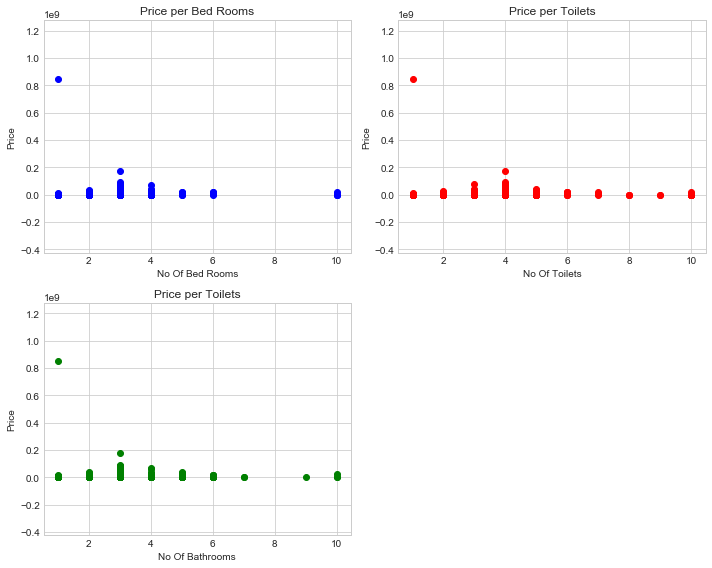

In [11]:
plt.figure(figsize=(10,8))

low = np.min(df['price'])
high = np.max(df['price'])

plt.subplot(2, 2, 1)
plt.scatter(x=df['no_bed'], y=df['price'], color='blue')
plt.title('Price per Bed Rooms')
plt.xlabel('No Of Bed Rooms')
plt.ylabel('Price')
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.subplot(2, 2, 2)
plt.scatter(df['no_toilets'], df['price'], color='red')
plt.title('Price per Toilets')
plt.xlabel('No Of Toilets')
plt.ylabel('Price')
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.subplot(2, 2, 3)
plt.scatter(df['no_bath'], df['price'], color='green')
plt.title('Price per Toilets')
plt.xlabel('No Of Bathrooms')
plt.ylabel('Price')
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.tight_layout()
plt.show()

## Treating Outliers

In [12]:
df['price'] = df['price'].astype('int')
df[df['price'] > 800000000]

,lat,lng,no_bath,no_bed,no_toilets,price
7167,6.469664,3.574369,1,1,1,850000000


In [13]:
df = df[df['price'] < 800000000]

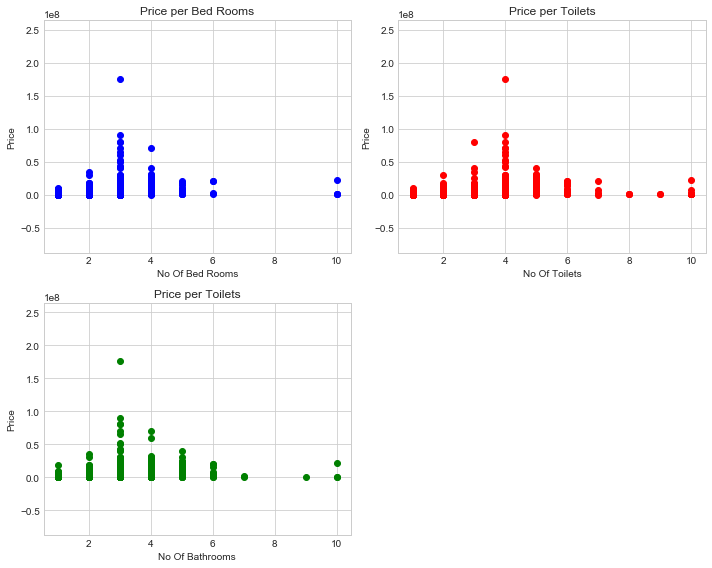

In [14]:
plt.figure(figsize=(10,8))

low = np.min(df['price'])
high = np.max(df['price'])

plt.subplot(2, 2, 1)
plt.scatter(x=df['no_bed'], y=df['price'], color='blue')
plt.title('Price per Bed Rooms')
plt.xlabel('No Of Bed Rooms')
plt.ylabel('Price')
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.subplot(2, 2, 2)
plt.scatter(df['no_toilets'], df['price'], color='red')
plt.title('Price per Toilets')
plt.xlabel('No Of Toilets')
plt.ylabel('Price')
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.subplot(2, 2, 3)
plt.scatter(df['no_bath'], df['price'], color='green')
plt.title('Price per Toilets')
plt.xlabel('No Of Bathrooms')
plt.ylabel('Price')
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.tight_layout()
plt.show()

# Model Development

The accuracy of the model used would be measured using: 
   * **Mean Squared Error**: This is the average of the squares of the errors of all the datapoints in the given dataset.
   * **Explained Variance Score**: This score measures how well our model can account for the variation in our dataset.
   * **R2-score**: This tells us how well the unknown samples will be predicted by our model.

In [15]:
def accuracy(test, pred, log = False):
    acc = round(sm.mean_squared_error(test, pred), 2),
    
    if log is True:
        print("Mean Squared Error: ", acc)
    else:
        return acc

## Spliting data for train and test

In [16]:
price = pd.Series(df['price'], dtype='float32')
feature_final = df.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(feature_final,
                                                    price,
                                                    test_size = 0.2,
                                                    random_state = 1)

In [17]:
print("Training set has {} samples.", X_train.shape)
print("Testing set has {} samples.", y_train.shape)

Training set has {} samples. (5964, 5)
Testing set has {} samples. (5964,)


### Base Model Performance

In [18]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
y_train_pred = linear_regressor.predict(X_train)

In [20]:
accuracy(y_train, y_train_pred, True)

Mean Squared Error:  (20920596884097.148,)


In [21]:
y_test_pred = linear_regressor.predict(X_test)

In [22]:
accuracy(y_test, y_test_pred, True)

Mean Squared Error:  (6211747048841.8496,)


### Best Model Performance

In [49]:
def performance_metric(y_true, y_predict):
    return sm.r2_score(y_true, y_predict)

In [79]:
clf = DecisionTreeRegressor()

parameters = { 'max_depth': range(2, 100) } 
scorer = make_scorer(performance_metric)
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_dt = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_dt.predict(X_test)

print("Unoptimized model (%.2f)" % accuracy(predictions, y_test))
print("Optimized model  (%.2f)" % accuracy(best_predictions, y_test))

Unoptimized model (6097359253614.01)
Optimized model  (4442260750626.09)


In [80]:
clf = RandomForestRegressor()

parameters = { 'max_depth': range(2, 100) } 
scorer = make_scorer(performance_metric)
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_rf = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_rf.predict(X_test)

print("Unoptimized model (%.2f)" % accuracy(predictions, y_test))
print("Optimized model  (%.2f)" % accuracy(best_predictions, y_test))

Unoptimized model (5108040342249.42)
Optimized model  (3919506149491.36)


In [52]:
best_dt

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [53]:
best_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [54]:
clf_main = BaggingRegressor(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4), n_estimators=10, max_samples=1.0, n_jobs=-1, bootstrap=True)

predictions = (clf_main.fit(X_train, y_train)).predict(X_test)
best_predictions = best_dt.predict(X_test)

print("Bagged Optimized", accuracy(predictions, y_test))
print("Optimized model", accuracy(best_predictions, y_test))

Bagged Optimized (3916681130257.6802,)
Optimized model (4442260750626.0898,)


## Final Model

In [55]:
model = clf_main

In [56]:
df.head(n=15)

,lat,lng,no_bath,no_bed,no_toilets,price
0,6.470383,3.567407,4,3,3,1000000
1,6.583560,3.293578,1,1,2,250000
2,6.583560,3.293578,1,1,1,170000
3,6.453094,3.291062,2,2,3,1000000
4,6.500235,3.302859,2,3,2,1000000
5,6.437805,3.516615,2,2,3,1300000
6,6.564985,3.280998,1,1,1,250000
7,6.463783,3.128609,3,3,3,1600000
8,6.463783,3.128609,2,2,2,1800000
9,6.600680,3.383047,2,2,3,550000


In [57]:
sample = df[0:15].drop('price', axis=1)
sample

,lat,lng,no_bath,no_bed,no_toilets
0,6.470383,3.567407,4,3,3
1,6.583560,3.293578,1,1,2
2,6.583560,3.293578,1,1,1
3,6.453094,3.291062,2,2,3
4,6.500235,3.302859,2,3,2
5,6.437805,3.516615,2,2,3
6,6.564985,3.280998,1,1,1
7,6.463783,3.128609,3,3,3
8,6.463783,3.128609,2,2,2
9,6.600680,3.383047,2,2,3


In [59]:
sample_predict = model.predict(sample)

In [60]:
sample_predict

array([ 1107249.89238901,   529697.38503396,   438508.35637089,
        2584935.11867816,   779567.91164126,  1815914.03749269,
         440242.32200305,  1350144.70713179,  1002039.14069116,
         891864.96545438,  1065857.70214646,  1043247.92737376,
        1386929.80148522,   438508.35637089,   846643.72076772])

In [61]:
lekki = pd.DataFrame({ 'lng': [6.4698], 'lat': [3.5852], 'no_bed': [1], 'no_toilets': [1], 'no_bath': [1] })

In [62]:
lekki_predict = model.predict(lekki)

In [63]:
lekki_predict

array([ 1848225.86151272])

## Save Model

In [64]:
import os

In [65]:
s = pickle.dump(clf_main, open(os.path.join('./', 'model.pkl'), 'wb'), protocol=2)

In [66]:
loded_model = pickle.load(open('./model.pkl', 'rb'))

In [67]:
loded_model.predict(lekki)

array([ 1848225.86151272])

## Higher and Lower Bound Price Discovery

In [68]:
areas_df = pd.read_json('./areas.json')

In [69]:
areas_df

,lat,lng,name
0,6.650300,3.286000,Abule Egba
1,6.528610,3.135309,Agbara-Igbesa
2,6.615356,3.323782,Agege
3,6.472516,3.568616,Ajah
4,7.558791,6.601780,Ajaokuta
5,6.658440,3.263392,Alagbado
6,6.546609,3.238251,Alimosho
7,6.524379,3.379206,Amuwo Odofin
8,6.444641,3.364084,Apapa
9,6.444116,3.372984,Atlantic City


In [70]:
low = df[(df['lng'] == 6.4698) | (df['lat'] == 3.5852) | (df['no_bath'] == 1) | (df['no_bed'] == 1) | (df['no_toilets'] == 1) ]['price'].quantile(0.25)

In [71]:
df['no_toilets'] = df['no_toilets'].astype('int32')
df['no_bath'] = df['no_toilets'].astype('int32')
df['no_bed'] = df['no_toilets'].astype('int32')

In [72]:
df.to_csv("./data.csv")

In [73]:
high

176000000

In [74]:
cdf = pd.read_csv('./data.csv')

In [75]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7455 entries, 0 to 7454
Data columns (total 7 columns):
Unnamed: 0    7455 non-null int64
lat           7455 non-null float64
lng           7455 non-null float64
no_bath       7455 non-null int64
no_bed        7455 non-null int64
no_toilets    7455 non-null int64
price         7455 non-null int64
dtypes: float64(2), int64(5)
memory usage: 407.8 KB


In [3]:
lekki = pd.DataFrame({ 'lng': [6.4698], 'lat': [3.5852], 'no_bed': [1], 'no_toilets': [1], 'no_bath': [1] })

In [4]:
lekki.values

array([[3.5852, 6.4698, 1.    , 1.    , 1.    ]])